$\newcommand{\der}[2]{\frac{ \mathrm{d} #1 }{ \mathrm{d} #2 }}$

# Unmodeled Systems

Consider an inverted pendulum modeled as point mass at the end of a massless link. The link is attached to a fixed base with torque input. The angle from upright and the corresponding angular rate are measured.

With mass $m$, link length $l$, angle $\theta$, angular rate $\dot{\theta}$, and torque input $\tau$, the system dynamics are:

\begin{equation}
    \der{}{t} \begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix} = \begin{bmatrix} \dot{\theta} \\ \frac{g}{l}\sin{\theta} \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{ml^2} \end{bmatrix} \tau,
\end{equation}

In [1]:
from core.systems import InvertedPendulum

ip = InvertedPendulum(m=0.25, l=0.5)

In [2]:
from core.controllers import FBLinController, LQRController

from numpy import identity

Q = 10 * identity(2)
R = identity(1)
lqr = LQRController.build(ip, Q, R)
fb_lin = FBLinController(ip, lqr)

In [3]:
from numpy import array, linspace

x_0 = array([1, 0])
ts = linspace(0, 10, 1000 + 1)

xs, _ = ip.simulate(x_0, fb_lin, ts)

In [4]:
from matplotlib.pyplot import subplots, show

width = 8
height = 4

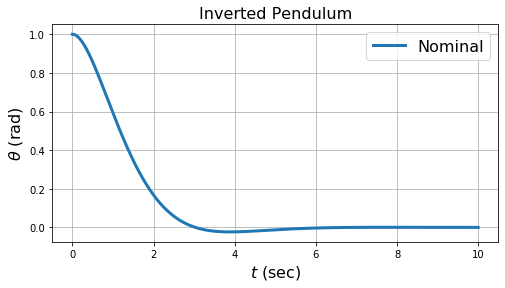

In [5]:
fig, ax = subplots(figsize=(width, height))
ax.plot(ts, xs[:, 0], linewidth=3, label='Nominal')
ax.grid()
ax.legend(fontsize=16)
ax.set_title('Inverted Pendulum', fontsize=16)
ax.set_xlabel('$t$ (sec)', fontsize=16)
ax.set_ylabel('$\\theta$ (rad)', fontsize=16)

show()

Suppose that the actuator dynamics are unmodeled, but can be specified as a first order filter of the form:

\begin{equation}
    \dot{\tau} + T\tau = T\tau_{cmd},
\end{equation}

with the system dynamics now represented as:

\begin{equation}
    \der{}{t} \begin{bmatrix} \theta \\ \dot{\theta} \\ \tau \end{bmatrix} = \begin{bmatrix} \dot{\theta} \\ \frac{g}{l} \sin{\theta} + \frac{1}{ml^2} \tau \\ T (\tau_{cmd} - \tau) \end{bmatrix}
\end{equation}

In [6]:
from numpy import concatenate

from core.dynamics import SystemDynamics

class ActuatedInvertedPendulum(SystemDynamics):
    def __init__(self, T, inverted_pendulum):
        SystemDynamics.__init__(self, 3, 1)
        self.T = T
        self.inverted_pendulum = inverted_pendulum
        
    def eval_dot(self, x, u, t):
        tau = x[-1:]
        x = x[:2]
        tau_dot = self.T * (u - tau)
        x_dot = self.inverted_pendulum.eval_dot(x, tau, t)
        return concatenate([x_dot, tau_dot])
    
aip = ActuatedInvertedPendulum(T=25, inverted_pendulum=ip)

In [7]:
from core.dynamics import FBLinDynamics

class InvertedPendulumOutput(FBLinDynamics):
    def __init__(self, inverted_pendulum):
        FBLinDynamics.__init__(self, [2])
        self.inverted_pendulum = inverted_pendulum
        
    def eval(self, x, t):
        return x[:-1]
    
    def drift(self, x, t):
        return self.inverted_pendulum.drift(x[:-1], t)
    
    def act(self, x, t):
        return self.inverted_pendulum.act(x[:-1], t)
    
ipo = InvertedPendulumOutput(ip)

In [8]:
from core.controllers import ConstantController

const = ConstantController(ipo, array([1]))

In [9]:
x_0 = array([1, 0, 0])

xs, us = aip.simulate(x_0, const, ts[:51])
taus = xs[:, -1]

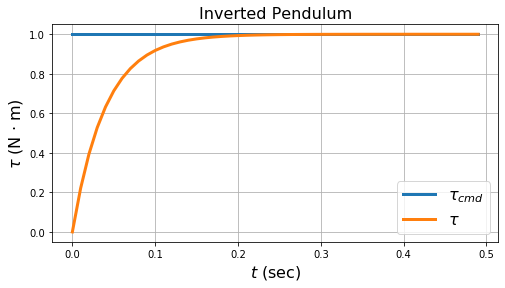

In [10]:
_, u_ax = subplots(figsize=(width, height))

u_ax.plot(ts[:50], us, linewidth=3, label='$\\tau_{cmd}$')
u_ax.plot(ts[:50], taus[:-1], linewidth=3, label='$\\tau$')
u_ax.grid()
u_ax.legend(fontsize=16)
u_ax.set_title('Inverted Pendulum', fontsize=16)
u_ax.set_xlabel('$t$ (sec)', fontsize=16)
u_ax.set_ylabel('$\\tau$ (N $\cdot$ m)', fontsize=16)

show()

In [11]:
lqr = LQRController.build(ipo, Q, R)
fb_lin = FBLinController(ipo, lqr)

In [12]:
xs, us = aip.simulate(x_0, fb_lin, ts)
xs, taus = xs[:, :2], xs[:, -1]

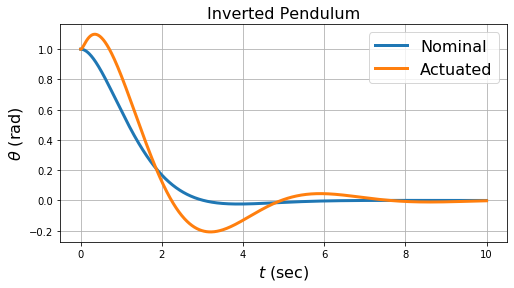

In [13]:
ax.plot(ts, xs[:, 0], linewidth=3, label='Actuated')
ax.legend(fontsize=16)

display(fig)

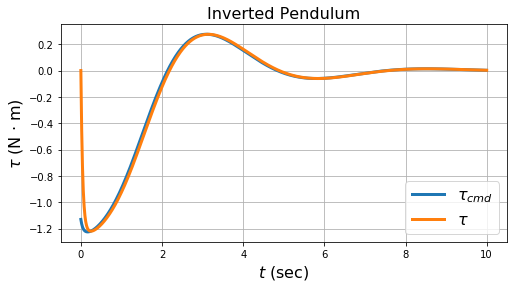

In [14]:
_, u_ax = subplots(figsize=(width, height))

u_ax.plot(ts[:-1], us, linewidth=3, label='$\\tau_{cmd}$')
u_ax.plot(ts, taus, linewidth=3, label='$\\tau$')
u_ax.grid()
u_ax.legend(fontsize=16)
u_ax.set_title('Inverted Pendulum', fontsize=16)
u_ax.set_xlabel('$t$ (sec)', fontsize=16)
u_ax.set_ylabel('$\\tau$ (N $\cdot$ m)', fontsize=16)

show()

In [15]:
from tensorflow.logging import ERROR, set_verbosity
set_verbosity(ERROR)

In [16]:
from core.dynamics import LearnedFBLinDynamics
from core.learning.keras import KerasResidualAffineModel

class LearnedInvertedPendulum(LearnedFBLinDynamics):
    def __init__(self, inverted_pendulum, res_model):
        LearnedFBLinDynamics.__init__(self, inverted_pendulum, res_model)
        
    def process_drift(self, x, t):
        return x
    
    def process_act(self, x, t):
        return x[:1]
    
d_drift_in = 2
d_act_in = 1
d_hidden = 20
d_out = 1
    
res_model = KerasResidualAffineModel(d_drift_in, d_act_in, d_hidden, 1, d_out, 'adam')
lip = LearnedInvertedPendulum(ip, res_model)

data = lip.process_episode(xs, us, ts)
lip.fit(data, num_epochs=10)

lipo = InvertedPendulumOutput(lip)

Using TensorFlow backend.


Epoch 1/10
998/998 [==============================] - 3s 3ms/step - loss: 0.1074
Epoch 2/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0744
Epoch 3/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0728
Epoch 4/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0733
Epoch 5/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0730
Epoch 6/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0721
Epoch 7/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0720
Epoch 8/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0721
Epoch 9/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0719
Epoch 10/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0716


In [17]:
lqr = LQRController.build(lipo, Q, R)
fb_lin = FBLinController(lipo, lqr)

In [18]:
xs, us = aip.simulate(x_0, fb_lin, ts)

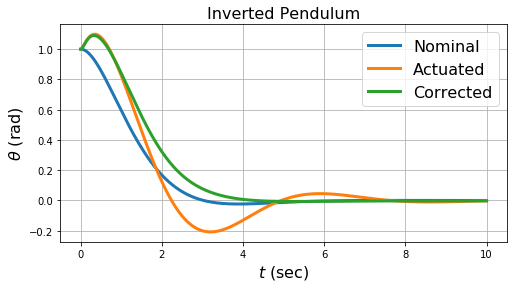

In [19]:
ax.plot(ts, xs[:, 0], linewidth=3, label='Corrected')
ax.legend(fontsize=16)

display(fig)